In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_final = pd.read_csv('data\COVID-19-final.csv', ';')
df_final.head()

,code,country,gdp,hdi,uhc,pop_0_14,pop_15_64,pop_65+,week,prev_cases,prev_deaths,cases,deaths
0,AFG,Afghanistan,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,1,0.000000,0.0,0.002629,0.000000
1,AFG,Afghanistan,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,2,0.002629,0.0,0.010515,0.000000
2,AFG,Afghanistan,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,3,0.010515,0.0,0.042059,0.000000
3,AFG,Afghanistan,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,4,0.042059,0.0,0.089375,0.000000
4,AFG,Afghanistan,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,5,0.089375,0.0,0.299671,0.010515


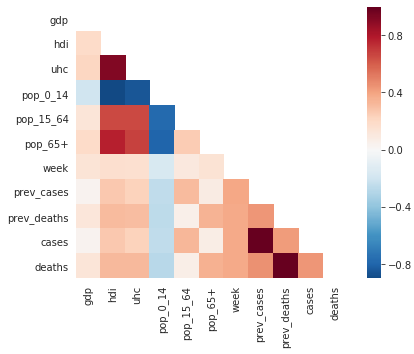

In [3]:
corr = df_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, center=0, cmap='RdBu_r', square=True)

# Treinamento

In [4]:
X = df_final[['gdp','hdi','uhc','pop_0_14','pop_15_64','pop_65+','week','prev_cases','prev_deaths']]
X.head()

,gdp,hdi,uhc,pop_0_14,pop_15_64,pop_65+,week,prev_cases,prev_deaths
0,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,1,0.000000,0.0
1,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,2,0.002629,0.0
2,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,3,0.010515,0.0
3,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,4,0.042059,0.0
4,8.273686e+10,0.496,0.37,0.430902,0.543249,0.025849,5,0.089375,0.0


In [5]:
y = df_final[['cases','deaths']]
y.head()

,cases,deaths
0,0.002629,0.000000
1,0.010515,0.000000
2,0.042059,0.000000
3,0.089375,0.000000
4,0.299671,0.010515


In [6]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [7]:
random_state = 40
n_splits = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
kf = KFold(n_splits)

print('train: X', X_train.shape, '- y', y_train.shape, '- KFold splits', n_splits)
print(' test: X', X_test.shape, '- y', y_test.shape)

train: X (2539, 9) - y (2539, 2) - KFold splits 10
 test: X (635, 9) - y (635, 2)


In [8]:
def kfold_train_validate(algoritmo, kf, X, y):
    historico = []
    
    for k, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        algoritmo.fit(X.iloc[train_idx], y.iloc[train_idx])
        r2s = algoritmo.score(X.iloc[val_idx], y.iloc[val_idx])
        historico.append([k, r2s])
    
    historico = pd.DataFrame(data=historico, columns=['k','r2 score'])
    return historico

def describe(historico):
    return pd.DataFrame(historico['r2 score']).describe().transpose()

def plot(historico):
    sns.lineplot(x='k', y='r2 score', data=historico)
    plt.show()

In [9]:
subject_countries = ['BRA','ESP','DEU','ITA','CHN','GBR','USA']

In [10]:
def plot_true_vs_pred(countries):
    if len(countries) > 1:
        cols = 2
        rows = math.ceil(len(countries) / 2.0)
    else:
        cols = 1
        rows = 1
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15,5*rows))
    
    axx = 0; axy = 0
    
    if len(countries) % 2 == 1:
        axs[rows-1, 1].remove()
    
    for country in countries:
        df_plot = df_final[df_final['code'] == country].sort_values(by=['week'])
        X_plot = df_plot[['gdp','hdi','uhc','pop_0_14','pop_15_64','pop_65+','week','prev_cases','prev_deaths']]
        df_plot['pred'] = algoritmo.predict(X_plot)
        
        ax = axs[axx,axy]
        
        ax.set_title(df_plot.iloc[0]['country'])
        sns.scatterplot(x='week', y='cases', data=df_plot, ax=ax, color='b', label='True')
        sns.lineplot(x='week', y='pred', data=df_plot, ax=ax, color='r', label='Pred')
        ax.set_ylabel('cases')
        
        if axy == 1:
            axx = axx + 1
            axy = 0;
        else:
            axy = 1;
        
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [11]:
y_var = 'cases'
y_train = y_train[y_var]

In [12]:
kernel='rbf' #linear
degree=3
gamma='scale' #auto
C = 1.0
epsilon = 0.1

algoritmo = SVR(kernel=kernel, degree=degree,gamma=gamma, C=C, epsilon=epsilon)

In [13]:
historico = kfold_train_validate(algoritmo, kf, X_train, y_train)
describe(historico)

,count,mean,std,min,25%,50%,75%,max
r2 score,10.0,-0.135904,0.036777,-0.178127,-0.172286,-0.137331,-0.103552,-0.084762


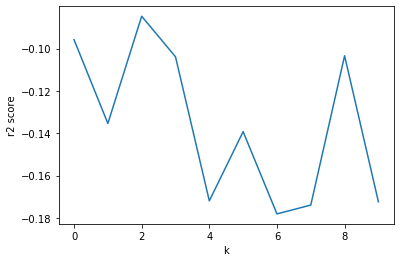

In [14]:
plot(historico)

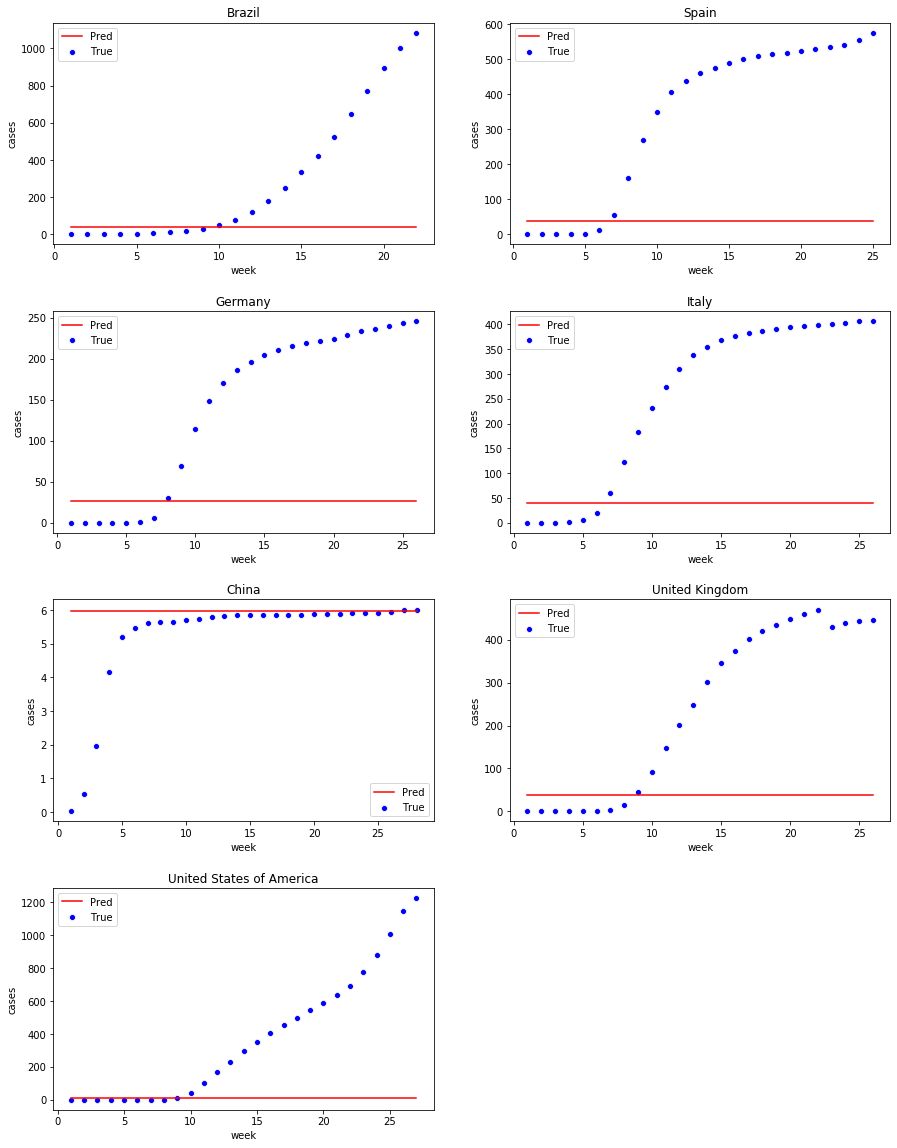

In [15]:
plot_true_vs_pred(subject_countries)

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
algoritmo = make_pipeline(StandardScaler(), SVR(kernel=kernel, degree=degree, gamma=gamma, C=C, epsilon=epsilon))

In [18]:
historico = kfold_train_validate(algoritmo, kf, X_train, y_train)
describe(historico)

,count,mean,std,min,25%,50%,75%,max
r2 score,10.0,0.154437,0.096562,0.041332,0.090142,0.110285,0.221966,0.330763


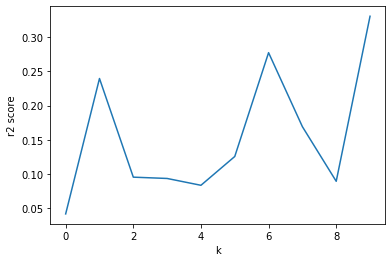

In [19]:
plot(historico)

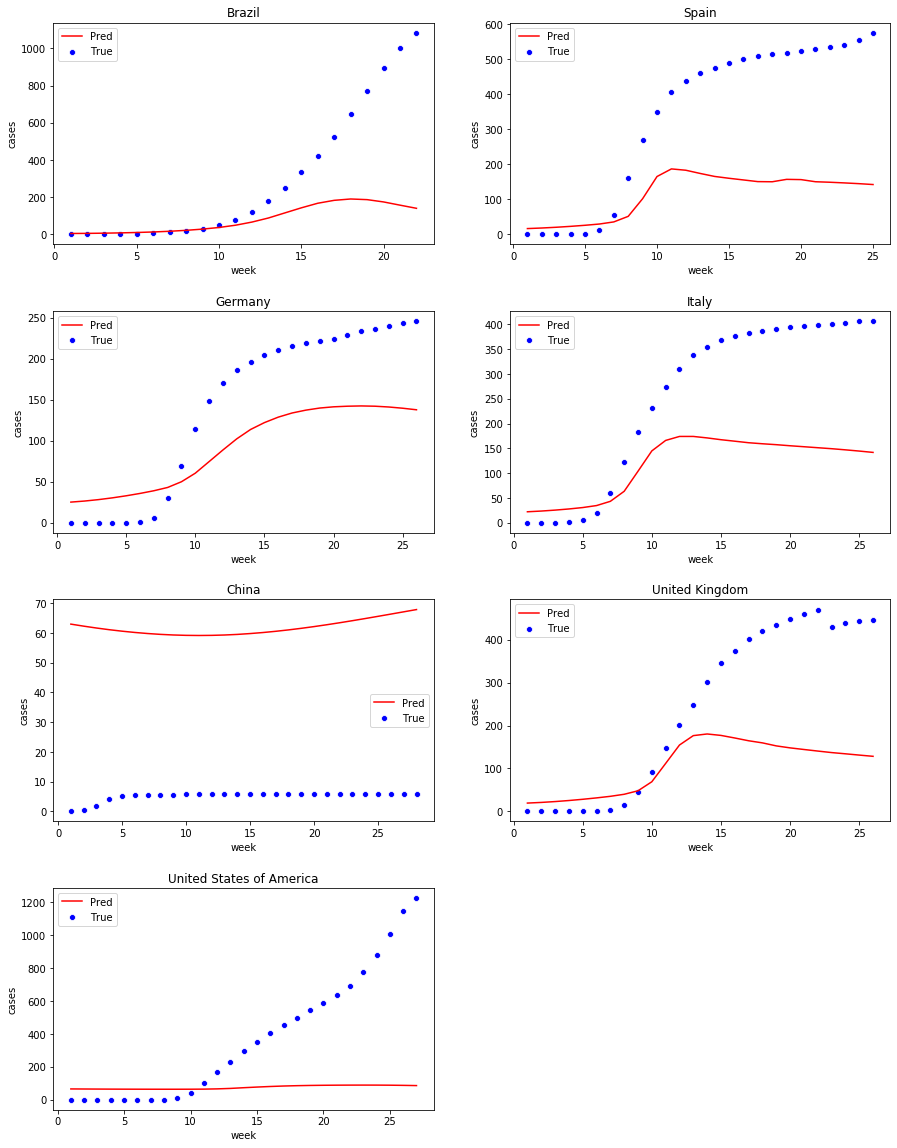

In [20]:
plot_true_vs_pred(subject_countries)

In [21]:
C=1000.0
epsilon=0.001
degree=3

algoritmo = make_pipeline(StandardScaler(), SVR(kernel=kernel, degree=degree, gamma=gamma, C=C, epsilon=epsilon))

In [22]:
historico = kfold_train_validate(algoritmo, kf, X_train, y_train)
describe(historico)

,count,mean,std,min,25%,50%,75%,max
r2 score,10.0,0.987919,0.010833,0.959773,0.988048,0.991482,0.993305,0.99676


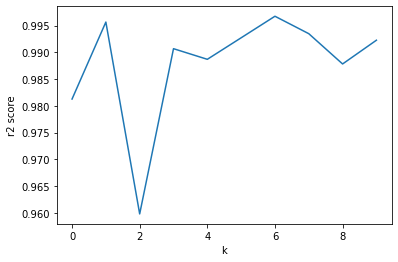

In [23]:
plot(historico)

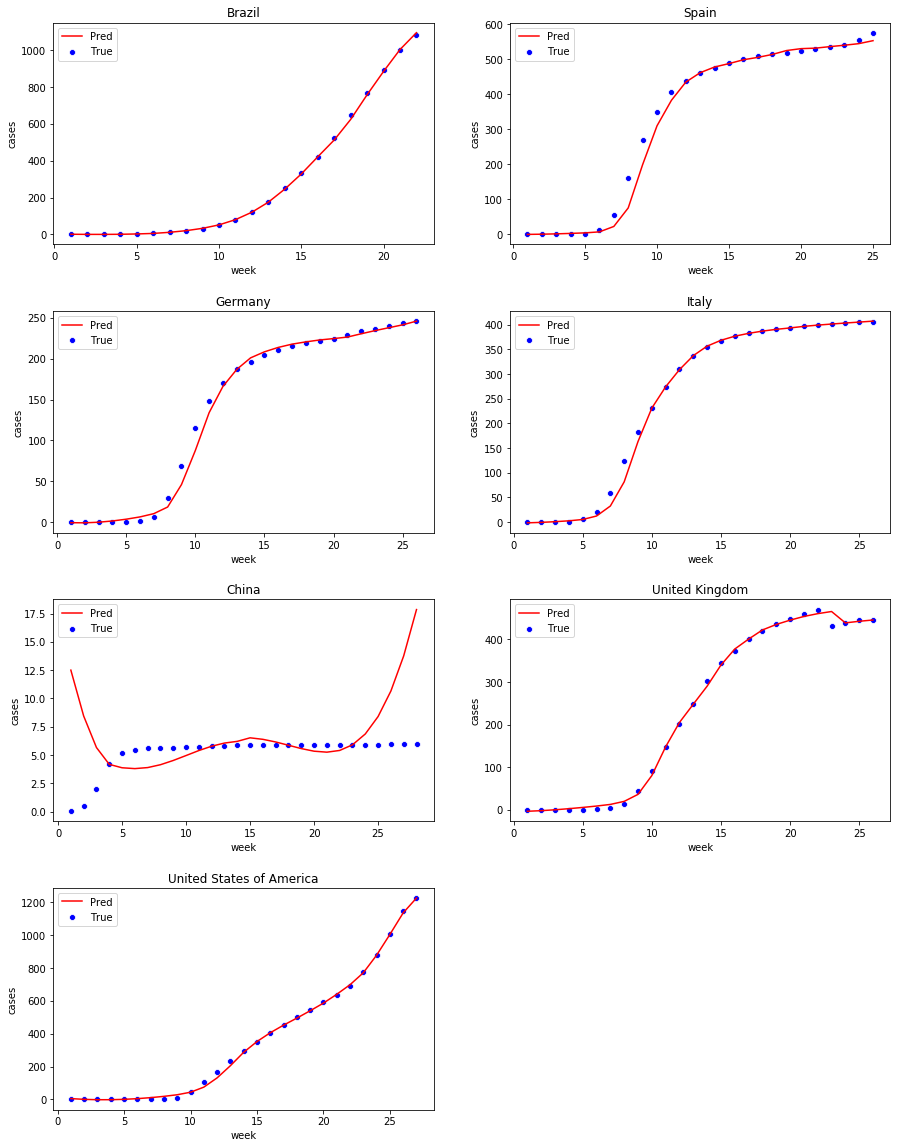

In [24]:
plot_true_vs_pred(subject_countries)

# Teste

In [25]:
r2s_test = algoritmo.score(X_test, y_test['cases'])
print("Test R2 score: {:3.6f}".format(r2s_test))

Test R2 score: 0.997163
